In [1]:
# Note: Install yfinance and tensorflow APIs only if you don't have them (e.g., you get an error message when referring to them in your code)

#!pip3 install yfinance

In [2]:
#Load Packages
import yfinance as yf
import os
import time
import numpy as np
import scipy as sci
import scipy.io as sio
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow import keras
from numpy.random import seed
seed(100)
import matplotlib.pyplot as plt
from IPython.display import clear_output

### For this project, I have decided to create an investment portfolio for the Nasdaq index, and I have chosen QQQ ETF to track the Nasdaq index.

- The Nasdaq-100 Index includes 100 of the largest domestic and international non-financial companies listed on The Nasdaq Stock Market based on market capitalization. The Index reflects companies across major industry groups, including computer hardware and software, telecommunications, retail/wholesale trade, and biotechnology. It does not contain securities of financial companies, including investment companies.
- For Nasdaq-100, I chose QQQ, which is managed by Invesco, and followed the associated web link.

## Part 1 - Data Preparation

In [3]:
start_time = time.time()    # This is to start the clock to measure how long it takes to run the whole program

raw_QQQ = pd.read_csv("holdings_1750537492999.csv")
# get raw data on IBBQ, an ETF that tracks the NDX
print("Size of the dataset (row, col): ", raw_QQQ.shape)
raw_QQQ

Size of the dataset (row, col):  (101, 10)


,Fund Ticker,Security Identifier,Holding Ticker,Shares/Par Value,MarketValue,Weight,Name,Class of Shares,Sector,Date
0,QQQ,594918104,MSFT,"62,098,845","29,645,988,603.00",8.850,Microsoft Corp,Common Stock,Information Technology,06/20/2025
1,QQQ,67066G104,NVDA,"203,861,803","29,325,520,361.55",8.754,NVIDIA Corp,Common Stock,Information Technology,06/20/2025
2,QQQ,037833100,AAPL,"124,788,680","25,082,524,680.00",7.488,Apple Inc,Common Stock,Information Technology,06/20/2025
3,QQQ,023135106,AMZN,"88,699,554","18,599,409,478.26",5.552,Amazon.com Inc,Common Stock,Consumer Discretionary,06/20/2025
4,QQQ,11135F101,AVGO,"64,973,259","16,242,665,017.41",4.849,Broadcom Inc,Common Stock,Information Technology,06/20/2025
...,...,...,...,...,...,...,...,...,...,...
96,QQQ,12514G108,CDW,"2,706,835","461,840,187.70",0.138,CDW Corp/DE,Common Stock,Information Technology,06/20/2025
97,QQQ,682189105,ON,"8,589,831","453,714,873.42",0.135,ON Semiconductor Corp,Common Stock,Information Technology,06/20/2025
98,QQQ,G39387108,GFS,"11,365,337","425,859,177.39",0.127,GLOBALFOUNDRIES Inc,Common Stock,Information Technology,06/20/2025
99,QQQ,042068205,ARM,"2,749,940","398,851,297.60",0.119,ARM Holdings PLC ADR,American Depository Receipt,Information Technology,06/20/2025


In [4]:
# List of stocks that form the NASDAQ
QQQ_tickers = raw_QQQ['Holding Ticker']
QQQ_tickers

0      MSFT 
1      NVDA 
2      AAPL 
3      AMZN 
4      AVGO 
       ...  
96      CDW 
97       ON 
98      GFS 
99      ARM 
100    BIIB 
Name: Holding Ticker, Length: 101, dtype: object

In [5]:
# Loading the data from yfinance
#NDX (Nasdaq) history over the past 5 years
#NDX_values = yf.Ticker('^NDX').history(period='5y')

NDX_values = yf.download('^NDX',start='2020-06-12',end='2025-06-20', interval="1d", auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [6]:
NDX_values

Price,Close,High,Low,Open,Volume
Ticker,^NDX,^NDX,^NDX,^NDX,^NDX
Date,,,,,
2020-06-12,9663.780273,9849.009766,9499.089844,9785.580078,4388990000
2020-06-15,9776.889648,9809.410156,9489.580078,9517.139648,4476010000
2020-06-16,9949.370117,10010.889648,9801.450195,9983.650391,4669320000
2020-06-17,9982.480469,10058.650391,9952.500000,9998.860352,4279700000
2020-06-18,10012.049805,10018.559570,9942.110352,9972.349609,4335320000
...,...,...,...,...,...
2025-06-12,21913.320312,21952.000000,21807.000000,21826.789062,16308730000
2025-06-13,21631.039062,21838.470703,21591.109375,21675.939453,9001850000


In [7]:
# Get NDX closing values
NDX_close = NDX_values[["Close"]]

In [8]:
# Note that if you reference elements of IBBQ_tickers, you will get a trailing whitespace
# that can create a problem when reading in the corresponding data through yfinance as a block
# For example,
ticker=QQQ_tickers[0]
ticker

'MSFT '

In [9]:
# clean the space in QQQ_tickers- This will replace the space from the code
tickers=[]
for ticker in QQQ_tickers:
    tickers.append(ticker.strip())

In [10]:
# We can now get all the price data for the stocks in the NBI
df_data_download = yf.download(tickers,start='2020-06-12',end='2025-06-20', interval="1d", auto_adjust=True)

[*********************100%***********************]  101 of 101 completed


In [11]:
df_data_download.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1261 entries, 2020-06-12 to 2025-06-18
Columns: 505 entries, ('Close', 'AAPL') to ('Volume', 'ZS')
dtypes: float64(412), int64(93)
memory usage: 4.9 MB


In [12]:
df_data_download

Price            Close                                                  \
Ticker            AAPL        ABNB        ADBE         ADI         ADP   
Date                                                                     
2020-06-12   82.334251         NaN  406.540009  108.279755  132.465439   
2020-06-15   83.352493         NaN  401.339996  108.362053  132.717773   
2020-06-16   85.561523         NaN  411.670013  112.193604  136.763565   
2020-06-17   85.442436         NaN  413.489990  112.047272  135.772354   
2020-06-18   85.476471         NaN  420.459991  112.303345  136.718491   
...                ...         ...         ...         ...         ...   
2025-06-12  199.199997  138.809998  413.679993  232.119995  308.209991   
2025-06-13  196.449997  135.539993  391.679993  225.029999  306.820007   
2025-06-16  198.419998  137.210007  401.730011  231.800003  307.910004   
2025-06-17  195.639999  133.369995  382.679993  227.440002  307.619995   
2025-06-18  196.580002  132.169998  378.040009  229.649994  306.769989   

Price                                                                   ...  \
Ticker            ADSK         AEP        AMAT         AMD        AMGN  ...   
Date                                                                    ...   
2020-06-12  222.960007   68.091438   54.075855   53.500000  186.482880  ...   
2020-06-15  229.000000   68.058151   54.553970   54.680000  188.091782  ...   
2020-06-16  240.929993   67.924950   55.978775   54.459999  194.159561  ...   
2020-06-17  237.039993   68.466019   57.374916   54.549999  193.389297  ...   
2020-06-18  238.070007   68.066467   57.738277   54.040001  197.112137  ...   
...                ...         ...         ...         ...         ...  ...   
2025-06-12  298.570007  103.019997  175.000000  118.500000  297.290009  ...   
2025-06-13  292.160004  102.900002  170.589996  116.160004  295.220001  ...   
2025-06-16  299.299988  101.910004  176.550003  126.389999  295.559998  ...   
2025-06-17  296.850006  101.620003  174.089996  127.099998  290.049988  ...   
2025-06-18  295.190002  101.199997  172.839996  126.790001  289.630005  ...   

Price          Volume                                                          \
Ticker           TSLA       TTD     TTWO      TXN     VRSK     VRTX       WBD   
Date                                                                            
2020-06-12  251451000  13015000  2586200  5950800   824600  1530100   6885900   
2020-06-15  235458000  21650000  2109400  5152800  1026000  1385400   5444900   
2020-06-16  210766500  17620000  1408100  3529000   674700  1557200   7255200   
2020-06-17  148362000  18035000  2006800  2934000   520900  1645100   3807500   
2020-06-18  146278500  17922000  1108100  3062500   617700  1371900   2855900   
...               ...       ...      ...      ...      ...      ...       ...   
2025-06-12  105127500   7536600  1441000  3257600   521600  1074500  58726200   
2025-06-13  128964300   6705000  2011400  5138200   544000  1021500  39383800   
2025-06-16   83925900   8309800  2220100  5864500   707000  1029900  46714400   
2025-06-17   88282700   8412900  1713100  4656300   537300  1363300  46816600   
2025-06-18   95137700   6321600  2510600  3742000   688400  1380300  45179700   

Price                                  
Ticker         WDAY      XEL       ZS  
Date                                   
2020-06-12  1635400  3376700  2010500  
2020-06-15  3053400  2770500  2664600  
2020-06-16  1757100  2886500  3334300  
2020-06-17  1535600  2529000  2505700  
2020-06-18  1785500  2941600  5456700  
...             ...      ...      ...  
2025-06-12  1965500  2569200  1827400  
2025-06-13  2199200  2861400  2066600  
2025-06-16  1825600  3343500  2567400  
2025-06-17  1818500  3460200  2885300  
2025-06-18  2472700  2917100  2019900  

[1261 rows x 505 columns]

In [13]:
df_data_download.columns

MultiIndex([( 'Close', 'AAPL'),
            ( 'Close', 'ABNB'),
            ( 'Close', 'ADBE'),
            ( 'Close',  'ADI'),
            ( 'Close',  'ADP'),
            ( 'Close', 'ADSK'),
            ( 'Close',  'AEP'),
            ( 'Close', 'AMAT'),
            ( 'Close',  'AMD'),
            ( 'Close', 'AMGN'),
            ...
            ('Volume', 'TSLA'),
            ('Volume',  'TTD'),
            ('Volume', 'TTWO'),
            ('Volume',  'TXN'),
            ('Volume', 'VRSK'),
            ('Volume', 'VRTX'),
            ('Volume',  'WBD'),
            ('Volume', 'WDAY'),
            ('Volume',  'XEL'),
            ('Volume',   'ZS')],
           names=['Price', 'Ticker'], length=505)

In [14]:
# The dataframe has 505 columns
#Let's keep the columns we do need (to compute returns based on closing prices as return = (close_{t} - close{t-1})/Close_{t})
data1 = df_data_download['Close']

In [15]:
data1

Ticker,AAPL,ABNB,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,...,TSLA,TTD,TTWO,TXN,VRSK,VRTX,WBD,WDAY,XEL,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-12,82.334251,NaN,406.540009,108.279755,132.465439,222.960007,68.091438,54.075855,53.500000,186.482880,...,62.352001,35.451000,134.000000,107.773621,157.696625,268.559998,22.07,173.550003,54.453999,102.470001
2020-06-15,83.352493,NaN,401.339996,108.362053,132.717773,229.000000,68.058151,54.553970,54.680000,188.091782,...,66.059998,37.060001,137.149994,107.999641,160.343155,267.769989,22.75,178.000000,54.334217,104.519997
2020-06-16,85.561523,NaN,411.670013,112.193604,136.763565,240.929993,67.924950,55.978775,54.459999,194.159561,...,65.475334,37.202999,135.669998,109.634033,161.331955,273.769989,22.26,181.139999,54.530987,102.809998
2020-06-17,85.442436,NaN,413.489990,112.047272,135.772354,237.039993,68.466019,57.374916,54.549999,193.389297,...,66.119331,38.243999,138.919998,109.729660,161.942734,280.089996,22.17,182.559998,54.659321,106.180000
2020-06-18,85.476471,NaN,420.459991,112.303345,136.718491,238.070007,68.066467,57.738277,54.040001,197.112137,...,66.930664,39.438999,141.250000,109.521011,161.748779,279.190002,22.52,187.809998,55.189747,113.050003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-12,199.199997,138.809998,413.679993,232.119995,308.209991,298.570007,103.019997,175.000000,118.500000,297.290009,...,319.109985,70.570000,234.460007,199.660004,313.459991,460.059998,10.16,250.690002,68.500000,301.429993
2025-06-13,196.449997,135.539993,391.679993,225.029999,306.820007,292.160004,102.900002,170.589996,116.160004,295.220001,...,325.309998,67.959999,230.229996,195.000000,310.410004,455.450012,10.03,244.539993,67.620003,301.950012
2025-06-16,198.419998,137.210007,401.730011,231.800003,307.910004,299.299988,101.910004,176.550003,126.389999,295.559998,...,329.130005,70.250000,238.600006,199.220001,309.470001,450.910004,10.76,245.649994,66.790001,305.019989


In [16]:
# Let's check our column names
data1.columns

Index(['AAPL', 'ABNB', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AEP', 'AMAT', 'AMD',
       'AMGN',
       ...
       'TSLA', 'TTD', 'TTWO', 'TXN', 'VRSK', 'VRTX', 'WBD', 'WDAY', 'XEL',
       'ZS'],
      dtype='object', name='Ticker', length=101)

In [17]:
#  We are now in position to compute the log returns
# To simplify notation in what follows, let's rename the dataframe:
df2 = data1

In [18]:
# Compute the log-returns and replace the columns entries, which previously were closing prices,
# with the log-returns (and relabel the columns as well)
for i in range(len(df2.columns)):
    df2.loc[:,df2.columns[i]]=np.log(df2.loc[:,df2.columns[i]]/df2.loc[:,df2.columns[i]].shift(1))
    df2.rename(columns={df2.columns[i]:df2.columns[i]+' log retn'}, inplace=True)

/var/folders/71/dvyytfpj799079751h_7f5tm0000gn/T/ipykernel_38392/1163821856.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.rename(columns={df2.columns[i]:df2.columns[i]+' log retn'}, inplace=True)


In [19]:
# The warning message above is related to the fact that we have NaN entries for some prices.
# Let's take a look at the returns just computed
df2

Ticker,AAPL log retn,ABNB log retn,ADBE log retn,ADI log retn,ADP log retn,ADSK log retn,AEP log retn,AMAT log retn,AMD log retn,AMGN log retn,...,TSLA log retn,TTD log retn,TTWO log retn,TXN log retn,VRSK log retn,VRTX log retn,WBD log retn,WDAY log retn,XEL log retn,ZS log retn
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-15,0.012291,NaN,-0.012873,0.000760,0.001903,0.026730,-0.000489,0.008803,0.021816,0.008591,...,0.057768,0.044387,0.023235,0.002095,0.016643,-0.002946,0.030346,0.025318,-0.002202,0.019808
2020-06-16,0.026157,NaN,0.025413,0.034748,0.030029,0.050784,-0.001959,0.025782,-0.004032,0.031750,...,-0.008890,0.003851,-0.010850,0.015020,0.006148,0.022160,-0.021774,0.017487,0.003615,-0.016496
2020-06-17,-0.001393,NaN,0.004411,-0.001305,-0.007274,-0.016278,0.007934,0.024635,0.001651,-0.003975,...,0.009788,0.027597,0.023673,0.000872,0.003779,0.022823,-0.004051,0.007809,0.002351,0.032253
2020-06-18,0.000398,NaN,0.016716,0.002283,0.006944,0.004336,-0.005853,0.006313,-0.009393,0.019068,...,0.012196,0.030768,0.016633,-0.001903,-0.001198,-0.003218,0.015664,0.028352,0.009657,0.062694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-12,0.002111,0.005418,0.002033,-0.001808,-0.008423,0.006047,0.010539,0.012709,-0.022034,0.018605,...,-0.022680,-0.025187,-0.001194,-0.000150,0.007739,0.016702,-0.033869,-0.002669,0.011943,0.005222
2025-06-13,-0.013901,-0.023839,-0.054648,-0.031021,-0.004520,-0.021703,-0.001165,-0.025523,-0.019944,-0.006987,...,0.019243,-0.037686,-0.018206,-0.023616,-0.009778,-0.010071,-0.012878,-0.024838,-0.012930,0.001724
2025-06-16,0.009978,0.012246,0.025335,0.029641,0.003546,0.024145,-0.009668,0.034341,0.084404,0.001151,...,0.011674,0.033141,0.035710,0.021410,-0.003033,-0.010018,0.070255,0.004529,-0.012350,0.010116


### Now that we have created the log returns, now we will use it to identify the so-called most communal and least communal stocks.

# Part 2 - Autoencoder part

In [20]:
# For each of the 101 stocks, run the NN model below

#Define a function the run the NN model
def model(X_train,X_vals,X_test):
    model = keras.models.Sequential([Dense(128,activation = "sigmoid",input_shape = (1,)),
                                     Dense(32,activation = "sigmoid"),
                                     Dense(128,activation = "sigmoid"),
                                     Dense(1,activation = "sigmoid")])
    model.compile(loss = "mse",optimizer = "Adam")
    checkpoint_cb = keras.callbacks.ModelCheckpoint("implied.h5",save_best_only = True)
    early_stopping_cb = keras.callbacks.EarlyStopping(patience = 1000,restore_best_weights = True)
    history=model.fit(X_train,X_train,epochs=500, batch_size = 32, verbose = 0, validation_data=(X_vals,X_vals),
                     callbacks=[checkpoint_cb, early_stopping_cb])
    model = keras.models.load_model("implied.h5")
    mse_test = model.evaluate(X_test,X_test,verbose=0)
    return mse_test

In [21]:
# Divide data into training set and test set
train,test=train_test_split(df2,test_size=0.2,random_state=100)

# Divide training set into training and validation set
train,validation=train_test_split(train,test_size=0.25,random_state=100)

In [22]:
# Let's take a look at the size of the data for the NN modeling 
print("train:",train.shape)
print("validation:",validation.shape)
print("test:",test.shape)

train: (756, 101)
validation: (252, 101)
test: (253, 101)


In [23]:
# So, according to the above, we are using 751 observations (returns) for training, 251 for validation, and 253 for testing
# Re-check the number of stocks
num_stocks = len(df2.columns)
num_stocks

101

In [24]:
# Create Autoencoder Model

# Here we create a model for each stock and, for each, save the resulting MSE
# We then rank (in the next cell) the stocks on the basis of the MSE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input


model=list(range(num_stocks))
mse_test=[]

for i in range (num_stocks):
    x_train=train.iloc[:,i].dropna()    #remove NaN values
    y_train=x_train
    x_val=validation.iloc[:,i].dropna()
    y_val=x_val
    x_test=test.iloc[:,i].dropna()
    y_test=x_test
    
    model[i] = Sequential([ Input(shape=(1,)),            # Define input layer correctly: input is return for one stock
                            Dense(20, activation="relu"),
                            Dense(5, activation="relu"),
                            Dense(20, activation="relu"),
                            Dense(1, activation="sigmoid") # Define output layer correctly: input is return for the same stock
                        ])

    
    model[i].compile(loss = "mse",optimizer = "Adam")

    history=model[i].fit(x_train,y_train,
                      epochs=100, 
                      batch_size = 128, 
                      validation_data= (x_val,y_val),
                      verbose = 0)
    
 # Calcuate  and save MSE for testing set   
    mse_test.append(model[i].evaluate(x_test,y_test,verbose=0))

In [25]:
# Here we list the stock in increasing order of MSE
print("stock #  |   mse   |      stock name")
ranking = np.array(mse_test).argsort()
for stock_index in ranking:
    print(stock_index, mse_test[stock_index], df2.iloc[:,stock_index].name) 

stock #  |   mse   |      stock name
79 0.00020929347374476492 PEP log retn
61 0.00021642436331603676 MDLZ log retn
27 0.00022410863311961293 COST log retn
9 0.00024911819491535425 AMGN log retn
90 0.00025420545716769993 TMUS log retn
84 0.0002590898366179317 ROP log retn
74 0.00027053369558416307 ORLY log retn
33 0.0002795843465719372 CTAS log retn
64 0.00028191113960929215 MNST log retn
4 0.0002827095449902117 ADP log retn
39 0.00029294341220520437 EXC log retn
48 0.0002932965289801359 HON log retn
99 0.0002989198255818337 XEL log retn
96 0.0003156903840135783 VRTX log retn
95 0.00032847418333403766 VRSK log retn
53 0.00033943186281248927 KDP log retn
34 0.0003414136590436101 CTSH log retn
38 0.00035261528682895005 EA log retn
28 0.00035725964698940516 CPRT log retn
41 0.00036550412187352777 FAST log retn
32 0.00037308913306333125 CSX log retn
26 0.00037675604107789695 CMCSA log retn
56 0.0003932553809136152 LIN log retn
6 0.0003950120590161532 AEP log retn
45 0.00040482435724698007 

## Part 3 - Build the portfolio based on the 10 "most communal" and the 15 "least communal stocks"

In [26]:
#Select 10 most communal and 15 least communal stocks
least_communal=15

# In this case we have a total of s stocks, where
s = 10 + least_communal  

stock_index = np.concatenate((ranking[0:10], ranking[-least_communal:]))
stock_index

array([79, 61, 27,  9, 90, 84, 74, 33, 64,  4, 29, 63, 65, 24, 91, 69, 35,
       97, 78, 87, 92, 80, 12, 13, 67])

In [27]:
#Portfolio with 25 stocks
port25 = df2.iloc[:, stock_index]
port25=port25.fillna(0)
port25

Ticker,PEP log retn,MDLZ log retn,COST log retn,AMGN log retn,TMUS log retn,ROP log retn,ORLY log retn,CTAS log retn,MNST log retn,ADP log retn,...,NFLX log retn,DASH log retn,WBD log retn,PDD log retn,SHOP log retn,TTD log retn,PLTR log retn,APP log retn,ARM log retn,MSTR log retn
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-06-15,0.011407,0.009613,-0.005102,0.008591,0.022901,0.010793,0.012977,0.001239,0.007294,0.001903,...,0.017616,0.000000,0.030346,0.060504,0.081295,0.044387,0.000000,0.000000,0.000000,0.038644
2020-06-16,0.009079,0.026206,0.013967,0.031750,-0.017248,0.011632,0.025038,0.026290,0.010123,0.030029,...,0.024675,0.000000,-0.021774,0.004240,0.000360,0.003851,0.000000,0.000000,0.000000,-0.005805
2020-06-17,0.000683,0.002469,-0.005824,-0.003975,-0.002530,0.008940,0.000188,-0.001280,0.000575,-0.007274,...,0.026339,0.000000,-0.004051,0.059719,0.014294,0.027597,0.000000,0.000000,0.000000,-0.001888
2020-06-18,0.007711,0.007183,-0.000133,0.019068,0.035981,-0.000249,-0.000915,0.009215,0.002442,0.006944,...,0.004679,0.000000,0.015664,-0.004600,0.054984,0.030768,0.000000,0.000000,0.000000,-0.018824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-12,0.018307,0.017325,0.005932,0.018605,-0.009747,0.004327,0.011488,0.008309,0.017422,-0.008423,...,-0.003984,-0.005525,-0.033869,0.002614,-0.044065,-0.025187,-0.008837,-0.007461,-0.012617,-0.019169
2025-06-13,-0.011020,-0.017624,-0.012545,-0.006987,-0.003065,-0.019916,-0.012600,-0.007137,-0.009941,-0.004520,...,-0.002373,0.010837,-0.012878,-0.027942,-0.036079,-0.037686,0.016215,-0.043197,-0.022396,0.008156
2025-06-16,0.004271,0.004175,-0.005925,0.001151,0.013029,0.008718,-0.020110,0.002205,0.012920,0.003546,...,0.010831,0.012571,0.070255,0.021735,0.028358,0.033141,0.028767,0.016840,0.046768,-0.001621


In [28]:
#Calculate index log return
idx_ret=np.log(NDX_close.pct_change()+1)
idx_ret=idx_ret.fillna(0)
idx_ret

Price,Close
Ticker,^NDX
Date,
2020-06-12,0.000000
2020-06-15,0.011636
2020-06-16,0.017488
2020-06-17,0.003322
2020-06-18,0.002958
...,...
2025-06-12,0.002400
2025-06-13,-0.012965


In [29]:
# Divide data into training set and test set
X_train1,X_test1,Y_train1,Y_test1=train_test_split(port25,idx_ret,test_size=0.2,random_state=100)

# Divide training set into training and validation set
X_train1,X_val1,Y_train1,Y_val1=train_test_split(X_train1,Y_train1,test_size=0.25,random_state=100)

In [30]:
# Create NN Index-Tracking Model 1
model1 = Sequential([
    Input(shape=(25,)),  # ✅ Define input layer explicitly
    Dense(10, activation="relu"),
    Dense(10, activation="relu"),
    Dense(25, activation="softmax")
])

# notice the softmax function, which generalizes the sigmoid from 1 dimension to multiple (i.e., 25 here) 
# to reflect portfolio allocation across 25 stocks

model1.summary()

Model: "sequential_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_404 (Dense)               │ (None, 10)             │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_405 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_406 (Dense)               │ (None, 25)             │           275 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 645 (2.52 KB)

 Trainable params: 645 (2.52 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Define a loss function to capture the (Euclidean) distance between the index performance and that 
# of the tracking portfolio above 

def custom_loss_function (x_values, y_values):
      squared_difference = tf.square(x_values-y_values) 
      return tf.reduce_mean(squared_difference, axis=-1)

In [32]:
#Compile NN Model 1
model1.compile(loss = custom_loss_function, optimizer = "Adam")

In [33]:
# Run Model 1 and collect performance in history 1
history1 = model1.fit(X_train1, Y_train1,
                     epochs=500, 
                     batch_size = 128, 
                     validation_data=(X_val1,Y_val1),
                     verbose = 0)   # you can set verbose to 0 to see the different iterations across epochs in detail

In [34]:
#Get the weights of stocks in the portfolio
weights1 = model1.predict(X_test1)
weights1 = weights1[0]
weights1

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


array([0.04000002, 0.04000001, 0.04000001, 0.04000001, 0.03999997,
       0.03999998, 0.03999998, 0.04000001, 0.03999999, 0.03999997,
       0.04      , 0.04      , 0.04000002, 0.04000001, 0.03999999,
       0.04      , 0.04      , 0.03999998, 0.04000002, 0.04      ,
       0.04000002, 0.04000001, 0.04000001, 0.04      , 0.03999999],
      dtype=float32)

In [35]:
#Calculate portfolio returns associated with these weights for the 25 stocks over different time periods
port_ret1 = np.dot(port25,weights1)
port_ret1

array([ 0.        ,  0.02039961,  0.00829209, ...,  0.01652115,
       -0.01168935,  0.00075794])

In [36]:
#Compare these portfolio returns based on the 25 stocks above with index returns
cl1 = custom_loss_function(np.array(port_ret1), np.array(idx_ret))
cl1.numpy()

array([0.0002553 , 0.00037226, 0.0005334 , ..., 0.000431  , 0.00037136,
       0.00025526])

In [37]:
# Mean error (loss) between index returns and index-tracking portfolio with a total of S = 25 stocks selected above
mean_loss1=np.mean(cl1)
mean_loss1

np.float64(0.00047807548685086415)

## Part 4 - Build the portfolio based on the 20 "most communal" and the 30 "least communal stocks"

In [38]:
#Select 20 most communal and 30 least communal stocks
least_communal=30

# In this case we have a total of s stocks, where
s = 20 + least_communal  

stock_index = np.concatenate((ranking[0:20], ranking[-least_communal:]))
stock_index

array([ 79,  61,  27,   9,  90,  84,  74,  33,  64,   4,  39,  48,  99,
        96,  95,  53,  34,  38,  28,  41,   7,   1,  42, 100,  89,  18,
        16,   8,  60,  73,  44,  62,  36,  40,  70,  29,  63,  65,  24,
        91,  69,  35,  97,  78,  87,  92,  80,  12,  13,  67])

In [39]:
#Portfolio with 50 stocks
port50 = df2.iloc[:, stock_index]
port50=port50.fillna(0)
port50

Ticker,PEP log retn,MDLZ log retn,COST log retn,AMGN log retn,TMUS log retn,ROP log retn,ORLY log retn,CTAS log retn,MNST log retn,ADP log retn,...,NFLX log retn,DASH log retn,WBD log retn,PDD log retn,SHOP log retn,TTD log retn,PLTR log retn,APP log retn,ARM log retn,MSTR log retn
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-06-15,0.011407,0.009613,-0.005102,0.008591,0.022901,0.010793,0.012977,0.001239,0.007294,0.001903,...,0.017616,0.000000,0.030346,0.060504,0.081295,0.044387,0.000000,0.000000,0.000000,0.038644
2020-06-16,0.009079,0.026206,0.013967,0.031750,-0.017248,0.011632,0.025038,0.026290,0.010123,0.030029,...,0.024675,0.000000,-0.021774,0.004240,0.000360,0.003851,0.000000,0.000000,0.000000,-0.005805
2020-06-17,0.000683,0.002469,-0.005824,-0.003975,-0.002530,0.008940,0.000188,-0.001280,0.000575,-0.007274,...,0.026339,0.000000,-0.004051,0.059719,0.014294,0.027597,0.000000,0.000000,0.000000,-0.001888
2020-06-18,0.007711,0.007183,-0.000133,0.019068,0.035981,-0.000249,-0.000915,0.009215,0.002442,0.006944,...,0.004679,0.000000,0.015664,-0.004600,0.054984,0.030768,0.000000,0.000000,0.000000,-0.018824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-12,0.018307,0.017325,0.005932,0.018605,-0.009747,0.004327,0.011488,0.008309,0.017422,-0.008423,...,-0.003984,-0.005525,-0.033869,0.002614,-0.044065,-0.025187,-0.008837,-0.007461,-0.012617,-0.019169
2025-06-13,-0.011020,-0.017624,-0.012545,-0.006987,-0.003065,-0.019916,-0.012600,-0.007137,-0.009941,-0.004520,...,-0.002373,0.010837,-0.012878,-0.027942,-0.036079,-0.037686,0.016215,-0.043197,-0.022396,0.008156
2025-06-16,0.004271,0.004175,-0.005925,0.001151,0.013029,0.008718,-0.020110,0.002205,0.012920,0.003546,...,0.010831,0.012571,0.070255,0.021735,0.028358,0.033141,0.028767,0.016840,0.046768,-0.001621


In [40]:
# Divide data into training set and test set
X_train2,X_test2,Y_train2,Y_test2=train_test_split(port50,idx_ret,test_size=0.2,random_state=100)

# Divide training set into training and validation set
X_train2,X_val2,Y_train2,Y_val2=train_test_split(X_train2,Y_train2,test_size=0.25,random_state=100)

In [41]:
# Create Index Tracking Model 2

model2 = Sequential([ Input(shape=(50,)),                            
                            Dense(20, activation="relu"),
                            Dense(50, activation="softmax")  
                        ])

model2.summary()

Model: "sequential_102"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_407 (Dense)               │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_408 (Dense)               │ (None, 50)             │         1,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,070 (8.09 KB)

 Trainable params: 2,070 (8.09 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
#Compile Model 2
model2.compile(loss = custom_loss_function, optimizer = "Adam")

In [43]:
history2 = model2.fit(X_train2, Y_train2,
                     epochs=500, 
                     batch_size = 128, 
                     validation_data=(X_val2,Y_val2),
                     verbose = 0)

In [44]:
#Get portfolio weights for the 45 stocks in this model #2
weights2 = model2.predict(X_test2)
weights2 = weights2[0]
weights2

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


array([0.01999963, 0.02000017, 0.02000005, 0.02000059, 0.01999961,
       0.01999955, 0.01999972, 0.02000073, 0.0199994 , 0.01999899,
       0.01999881, 0.02000044, 0.02000059, 0.01999904, 0.01999878,
       0.02000087, 0.02000075, 0.01999971, 0.01999976, 0.0199998 ,
       0.0199995 , 0.02000045, 0.02000045, 0.02000072, 0.02000033,
       0.02000023, 0.01999954, 0.01999994, 0.01999914, 0.01999896,
       0.02000045, 0.01999964, 0.01999985, 0.02000117, 0.02000015,
       0.02000031, 0.02000004, 0.02000025, 0.01999993, 0.01999998,
       0.02000069, 0.01999982, 0.02000076, 0.01999899, 0.02000038,
       0.01999985, 0.02000086, 0.02000034, 0.02000083, 0.01999946],
      dtype=float32)

In [45]:
#Calculate portfolio returns for these 50 stocks over different time periods
port_ret2 = np.dot(port50,weights2)
port_ret2

array([ 0.        ,  0.01898511,  0.00777147, ...,  0.01467659,
       -0.01024651,  0.00026739])

In [46]:
#Compare these portfolio returns with 50 stocks with index returns
cl2 = custom_loss_function(np.array(port_ret2), np.array(idx_ret))
cl2.numpy() 

array([0.00022173, 0.0003413 , 0.00050375, ..., 0.00040058, 0.00033554,
       0.00022169])

In [47]:
# Mean error (loss) between index returns and index-tracking portfolio with a total of S = 50 stocks selected above
mean_loss2=np.mean(cl2)
mean_loss2

np.float64(0.00044464551895225055)

## Note: The MSE of 0.000444 (4.44 basis points) with 50 stocks is smaller than the MSE of 0.000478 (4.78 basis points) with 25 stocks

# Plots:

## Returns of the index versus those of portfolios 1 and 2 identified above over the 5-year period

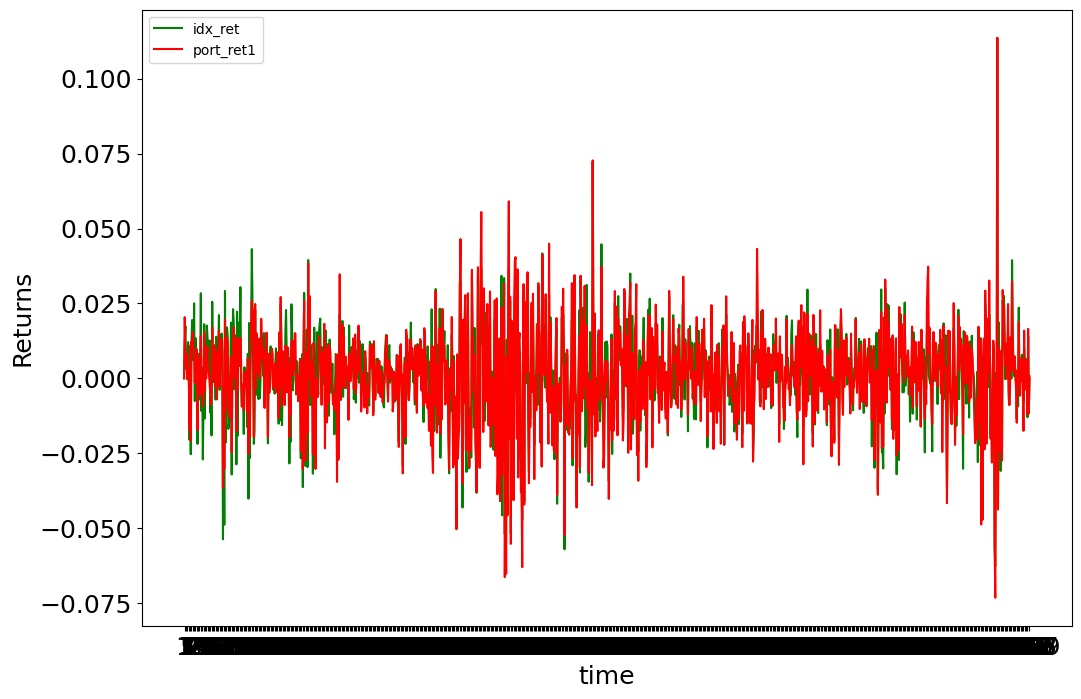

In [48]:
# Plot the returns of the index versus portfolio 1
# Number of time observations is:
numobs = len(NDX_values)

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [12,8] 
plt.plot(range(0,numobs),idx_ret,color='green', label='idx_ret')
plt.plot(range(0,numobs),port_ret1,color='red', label='port_ret1')

plt.xticks(range(1,numobs,2), fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel("Returns",fontsize = 18)
plt.xlabel("time", fontsize = 18)
plt.legend()
plt.show()

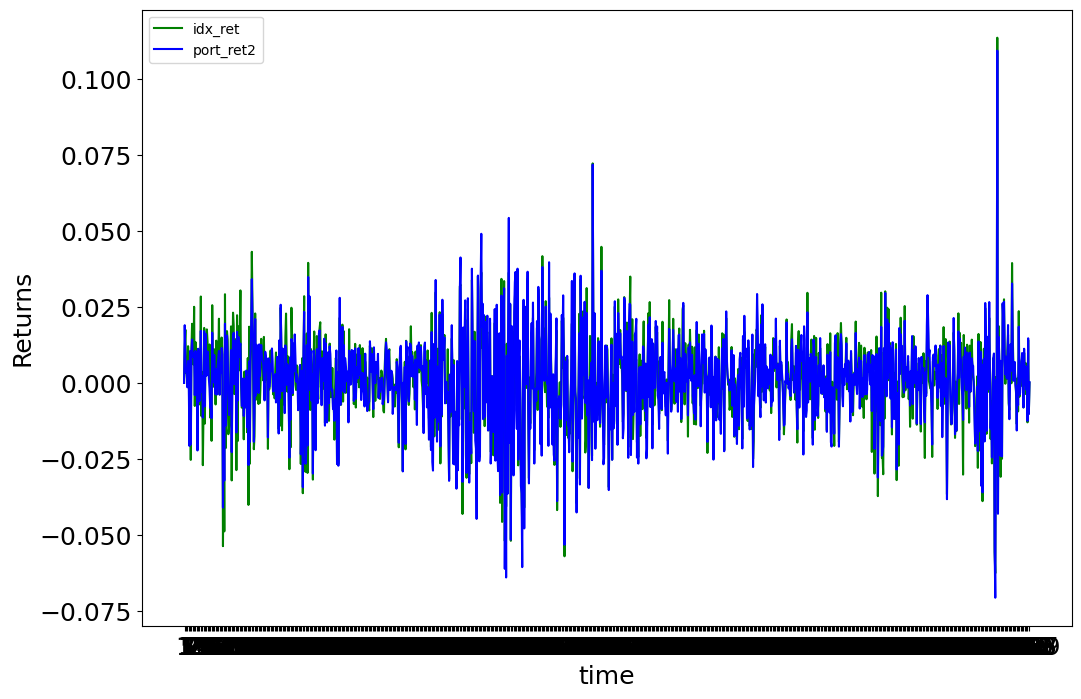

In [49]:
# Plot the returns of the index versus portfolio 2
%matplotlib inline
plt.rcParams['figure.figsize'] = [12,8] 
plt.plot(range(0,numobs),idx_ret,color='green', label='idx_ret')
plt.plot(range(0,numobs),port_ret2,color='blue', label='port_ret2')
plt.xticks(range(1,numobs,2), fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel("Returns",fontsize = 18)
plt.xlabel("time", fontsize = 18)
plt.legend()
plt.show()

In [50]:
end_time = time.time()   
end_time = time.time()
print("Execution time:", end_time - start_time, "seconds")

Execution time: 554.0429470539093 seconds
